In [1]:
import os
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

hyperparameters

In [2]:
test_size = 0.33
random_seed = 42
kf=10
score = 'f1_weighted'

#### somte sampling

In [3]:
def Smoter(X, y, is_random=False):
    if is_random == True:
        random_lst = list(np.random.randint(0, 1000, 4))
    elif is_random == False:
        random_lst = [0] * 4

    print("rs:", random_lst)
    sm = SMOTE(random_state=random_lst[2], kind = 0.24)
    X_smote, y_smote = sm.fit_sample(X, y)

    return X_smote, y_smote

# load data_four_features

In [4]:
path = os.getcwd()+'/../data/20122018freshwater_four_feature.csv'
data_four_features = pd.read_csv(path, na_values = np.nan)

print(data_four_features.dtypes)
print(data_four_features.shape)

pH             float64
DO(mg/l)       float64
CODMn(mg/l)    float64
NH3-N(mg/l)    float64
本周水质             int64
dtype: object
(33612, 5)


In [5]:
X = data_four_features.drop(['本周水质'], axis=1) # Series
y = data_four_features['本周水质']-1 # Series

In [6]:
data_four_features.describe()

,pH,DO(mg/l),CODMn(mg/l),NH3-N(mg/l),本周水质
count,33612.000000,33612.000000,33612.000000,33612.000000,33612.000000
mean,7.683118,8.101794,4.269093,0.559666,2.902892
std,0.544139,2.597636,3.352749,1.421597,1.260947
min,5.790000,-1.000000,-1.800000,0.000000,1.000000
25%,7.310000,6.640000,2.200000,0.150000,2.000000
50%,7.670000,8.050000,3.600000,0.240000,3.000000
75%,8.040000,9.550000,5.400000,0.440000,4.000000
max,10.190000,123.000000,110.800000,30.100000,6.000000


In [7]:
def status(x) : 
    return pd.Series([x.count(),x.min(),x.idxmin(),x.quantile(.25),x.median(),
                      x.quantile(.75),x.mean(),x.max(),x.idxmax(),x.mad(),x.var(),
                      x.std(),x.skew(),x.kurt()],index=['count*','min','argmin','25%',
                    'Median*','75%分位数','mean*','max','argmax','平均绝对偏差','var','Std. dev*','偏度(skew)','峰度(kurt)'])

In [8]:
df = pd.DataFrame({
    'pH': status(data_four_features['pH']),
    'DO(mg/l)': status(data_four_features['DO(mg/l)']),
    'CODMn(mg/l)': status(data_four_features['CODMn(mg/l)']),
    'NH3-N(mg/l)': status(data_four_features['NH3-N(mg/l)']),
})

df

,CODMn(mg/l),DO(mg/l),NH3-N(mg/l),pH
count*,33612.000000,33612.000000,33612.000000,33612.000000
min,-1.800000,-1.000000,0.000000,5.790000
argmin,18353.000000,28332.000000,823.000000,19116.000000
25%,2.200000,6.640000,0.150000,7.310000
Median*,3.600000,8.050000,0.240000,7.670000
75%分位数,5.400000,9.550000,0.440000,8.040000
mean*,4.269093,8.101794,0.559666,7.683118
max,110.800000,123.000000,30.100000,10.190000
argmax,27791.000000,2627.000000,28708.000000,9933.000000
平均绝对偏差,2.145157,1.905882,0.545110,0.432795


In [20]:
print("水质分布情况:")
print(y.value_counts()/y.count()*100)
print("\n各特征类型分布情况:")
print(data_four_features.dtypes.value_counts())

水质分布情况:
1    39.485898
2    26.172200
3    16.279900
0     7.253362
5     6.384625
4     4.424015
Name: 本周水质, dtype: float64

各特征类型分布情况:
float64    4
int64      1
dtype: int64


In [13]:
print("============ train_valid_split ============")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                       stratify = y, random_state = random_seed)
print("67%% train: %d/%d, 33%% test: %d/%d" %(X_train.shape[0], X.shape[0], X_test.shape[0], X.shape[0]))

============ train_valid_split ============
67% train: 22520/33612, 33% test: 11092/33612


#### Before normalize

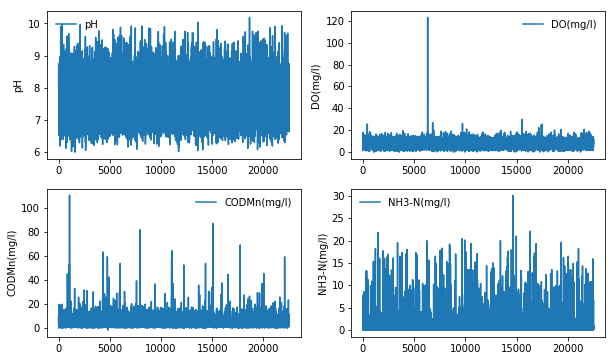

In [9]:
plt.figure(figsize=(10,6)) 
plt.subplot(2,2,1)
plt.plot(X_train.values[:,0], label = 'pH')
plt.ylabel('pH')
plt.legend(frameon=False)

plt.subplot(2,2,2)
plt.plot(X_train.values[:,1], label = 'DO(mg/l)')
plt.ylabel('DO(mg/l)')
plt.legend(frameon=False)

plt.subplot(2,2,3)
plt.plot(X_train.values[:,2], label = 'CODMn(mg/l)')
plt.ylabel('CODMn(mg/l)')
plt.legend(frameon=False)

plt.subplot(2,2,4)
plt.plot(X_train.values[:,3], label = 'NH3-N(mg/l)')
plt.ylabel('NH3-N(mg/l)')
plt.legend(frameon=False)

plt.savefig('../paper/img/before_z_score.eps',format='eps')

### normalize  train data

fulfill the Na with median, then standardized the data, output type ndarray

In [10]:
clean_pipeline = Pipeline([('imputer', preprocessing.Imputer(missing_values='NaN',strategy="median")),
                           ('std_scaler', preprocessing.StandardScaler()),])
X_train = clean_pipeline.fit_transform(X_train)
X_test = clean_pipeline.fit_transform(X_test)

#### After normalize

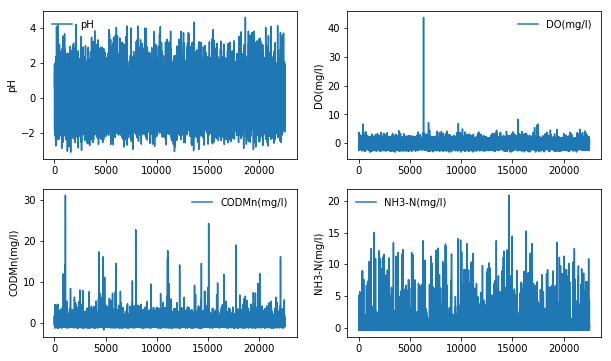

In [11]:
plt.figure(figsize=(10,6)) 
plt.subplot(2,2,1)
plt.plot(X_train[:,0], label = 'pH')
plt.ylabel('pH')
plt.legend(frameon=False)

plt.subplot(2,2,2)
plt.plot(X_train[:,1], label = 'DO(mg/l)')
plt.ylabel('DO(mg/l)')
plt.legend(frameon=False)

plt.subplot(2,2,3)
plt.plot(X_train[:,2], label = 'CODMn(mg/l)')
plt.ylabel('CODMn(mg/l)')
plt.legend(frameon=False)

plt.subplot(2,2,4)
plt.plot(X_train[:,3], label = 'NH3-N(mg/l)')
plt.ylabel('NH3-N(mg/l)')
plt.legend(frameon=False)
# 
plt.savefig('../paper/img/after_z_score.eps',format='eps')